# Описание задачи

**Задача бинарной классификации:** 

Требуется спрогнозировать вероятность отказа клиента от заказа

**Фичи:** 

Date - Плановая дата доставки до клиента

DateOrder - Дата оформления заказа

ClientID - ID клиента

ChannelID - Канал сбыта

OrderID - Номер заказа, присваевымый сайтом

MaterialID - ID материала

GroupID - Группа закупок ID

DeliveryType - Тип доставки

Cluster - Кластер доставки

Interval - Временной интервал доставки (с n-часов по n-часов)

OrderCnt - Заказано, шт

Prepay - Признак предоплаты

Count_edit - Число редактирований заказа клиентом, 1 (первоначальный
ввод) и больше

**Целевая переменная:**

CancelFlag - Метка отмены заказов

**Метрика:**

Задача бинарной классификации и классы несбалансированные => подойдёт метрика **ROC AUC** 

# Библиотеки

In [0]:
import pandas as pd
import numpy as np
import os

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
os.chdir("gdrive/My Drive/ITUniver")

# Подготовка данных

In [0]:
df = pd.read_csv('train_FeelAI.csv', encoding='cp1251')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6317412 entries, 0 to 6317411
Data columns (total 14 columns):
Interval        object
Date            object
OrderDate       object
ClientID        int64
ChannelID       int64
OrderID         int64
MaterialID      float64
GroupID         float64
Cluster         object
CancelFlag      int64
OrderCnt        float64
DeliveryType    object
prepay          int64
count_edit      int64
dtypes: float64(3), int64(6), object(5)
memory usage: 674.8+ MB


In [0]:
df

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit
0,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328810.0,61.0,NaN,0,1.0,Обычная доставка,0,1
1,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3281258.0,30.0,NaN,0,2.0,Обычная доставка,0,1
2,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3210734.0,10.0,NaN,0,1.0,Обычная доставка,0,1
3,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328848.0,61.0,NaN,0,2.0,Обычная доставка,0,1
4,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3347801.0,17.0,NaN,0,10.0,Обычная доставка,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6317407,8-10.,31/12/2018,30/12/2018,93114842,2,98357281213,3288611.0,35.0,HUB5,0,5.0,Обычная доставка,0,1
6317408,8-10.,31/12/2018,30/12/2018,93114842,2,98357281213,3141534.0,35.0,HUB5,0,1.0,Обычная доставка,0,1
6317409,8-10.,31/12/2018,30/12/2018,93114842,2,98357281213,3323302.0,36.0,HUB5,0,2.0,Обычная доставка,0,1
6317410,8-10.,31/12/2018,30/12/2018,93114842,2,98357281213,3051490.0,36.0,HUB5,0,1.0,Обычная доставка,0,1


In [0]:
df.isna().mean()

Interval        0.000000
Date            0.000000
OrderDate       0.000000
ClientID        0.000000
ChannelID       0.000000
OrderID         0.000000
MaterialID      0.000011
GroupID         0.000011
Cluster         0.628423
CancelFlag      0.000000
OrderCnt        0.000011
DeliveryType    0.000000
prepay          0.000000
count_edit      0.000000
dtype: float64

Удалим строки, в которых MaterialID = nan, так как относительно всего числа строк их малое кол-во

In [0]:
df = df[~df.MaterialID.isna()]

In [0]:
df.isna().mean()

Interval        0.000000
Date            0.000000
OrderDate       0.000000
ClientID        0.000000
ChannelID       0.000000
OrderID         0.000000
MaterialID      0.000000
GroupID         0.000000
Cluster         0.628419
CancelFlag      0.000000
OrderCnt        0.000000
DeliveryType    0.000000
prepay          0.000000
count_edit      0.000000
dtype: float64

In [0]:
df.Cluster.unique()

array([nan, 'HUB17', 'HUB6', 'HUB9', 'HUB7', 'HUB15', 'HUB4', 'HUB8',
       'HUB5', 'HUB20', 'HUB21', 'HUB2', 'HUB10', 'HUB1', 'HUB12',
       'HUB13', 'HUB11', 'HUB22', 'HUB19', 'HUB14', 'HUB3', 'HUB18',
       'HUB16', 'ZON1'], dtype=object)

Для Кластера доставки добавим новый класс Unknown

In [0]:
df.Cluster = df.Cluster.fillna('UNKNOWN')

Проверка данных на nan

In [0]:
df.isna().mean()

Interval        0.0
Date            0.0
OrderDate       0.0
ClientID        0.0
ChannelID       0.0
OrderID         0.0
MaterialID      0.0
GroupID         0.0
Cluster         0.0
CancelFlag      0.0
OrderCnt        0.0
DeliveryType    0.0
prepay          0.0
count_edit      0.0
dtype: float64

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6317342 entries, 0 to 6317411
Data columns (total 14 columns):
Interval        object
Date            object
OrderDate       object
ClientID        int64
ChannelID       int64
OrderID         int64
MaterialID      int64
GroupID         float64
Cluster         object
CancelFlag      int64
OrderCnt        float64
DeliveryType    object
prepay          int64
count_edit      int64
dtypes: float64(2), int64(7), object(5)
memory usage: 723.0+ MB


In [0]:
df.MaterialID = df.MaterialID.astype('int64')

In [0]:
df.ChannelID = df.ChannelID.astype('int64')

In [0]:
df.OrderCnt = df.OrderCnt.astype('int64')

In [0]:
df.GroupID = df.GroupID.astype('int64')

In [0]:
df.to_csv('train_FeelAI_prepared.csv', index=False)

# Первичный анализ данных

In [0]:
df = pd.read_csv('train_FeelAI_prepared.csv')

In [0]:
df

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit
0,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328810,61,UNKNOWN,0,1,Обычная доставка,0,1
1,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3281258,30,UNKNOWN,0,2,Обычная доставка,0,1
2,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3210734,10,UNKNOWN,0,1,Обычная доставка,0,1
3,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328848,61,UNKNOWN,0,2,Обычная доставка,0,1
4,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3347801,17,UNKNOWN,0,10,Обычная доставка,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6317337,8-10.,31/12/2018,30/12/2018,93114842,2,98357281213,3288611,35,HUB5,0,5,Обычная доставка,0,1
6317338,8-10.,31/12/2018,30/12/2018,93114842,2,98357281213,3141534,35,HUB5,0,1,Обычная доставка,0,1
6317339,8-10.,31/12/2018,30/12/2018,93114842,2,98357281213,3323302,36,HUB5,0,2,Обычная доставка,0,1
6317340,8-10.,31/12/2018,30/12/2018,93114842,2,98357281213,3051490,36,HUB5,0,1,Обычная доставка,0,1


В результате группировки можно потерять информативность признаков MaterialID, GroupID, OrderCnt

In [0]:
df.groupby(['OrderID']).nunique().mean()

Interval         1.000000
Date             1.000000
OrderDate        1.000000
ClientID         1.000000
ChannelID        1.000000
OrderID          1.000000
MaterialID      25.439405
GroupID         10.038622
Cluster          1.000000
CancelFlag       1.000000
OrderCnt         3.881371
DeliveryType     1.000000
prepay           1.000000
count_edit       1.000000
dtype: float64

Существуют ID материалов, по кот-ым были вседа отказы. Эту информацию требуется проверить на тестовой выборке и учесть при группировке

In [0]:
df.groupby(['MaterialID']).CancelFlag.mean().describe()

count    49591.000000
mean         0.059063
std          0.103357
min          0.000000
25%          0.000000
50%          0.037736
75%          0.072727
max          1.000000
Name: CancelFlag, dtype: float64

Заменим MaterialID на вещественную переменную

In [0]:
df_gr = df.groupby(['MaterialID']).CancelFlag.agg([np.mean, np.sum])

In [0]:
df_gr['entr'] = - df_gr['sum'] * np.log(df_gr['mean']+0.0000001)

In [0]:
df_entr = df.set_index('MaterialID').join(df_gr)['entr']

In [0]:
df['Material'] = df_entr.values

In [0]:
df_entr.to_csv('data_material.csv')

Разброс по GroupID незначительный, можно предположить, что данной фичей можно пренебречь

In [0]:
df.groupby(['GroupID']).CancelFlag.mean().describe()

count    48.000000
mean      0.058877
std       0.007614
min       0.046875
25%       0.053317
50%       0.057803
75%       0.061110
max       0.081733
Name: CancelFlag, dtype: float64

In [0]:
df = df.drop(['GroupID'], axis=1)

Данную переменную просуммируем

In [0]:
df.groupby(['OrderCnt']).CancelFlag.mean().describe()

count    180.000000
mean       0.080786
std        0.165011
min        0.000000
25%        0.000000
50%        0.033482
75%        0.079874
max        1.000000
Name: CancelFlag, dtype: float64

In [0]:
df_gr = df.groupby(['OrderID'])

In [0]:
df = df_gr.first()

In [0]:
df['Material'] = df_gr.Material.mean()

In [0]:
df['OrderCnt'] = df_gr.OrderCnt.sum()

In [0]:
df.to_csv('train_FeelAI_grouped.csv')

In [0]:
from datetime import datetime

In [0]:
def parse_dates(x):
    return datetime.strptime(x, "%d/%m/%Y")

In [0]:
df = pd.read_csv('train_FeelAI_grouped.csv', parse_dates=['Date', 'OrderDate'], date_parser=parse_dates)

Предоплата влияет на отмену заказа

In [84]:
round(pd.crosstab(df['CancelFlag'], df['prepay'])/len(df),2)

prepay,0,1
CancelFlag,,
0,0.72,0.21
1,0.06,0.01


AxesSubplot(0.125,0.125;0.775x0.755)


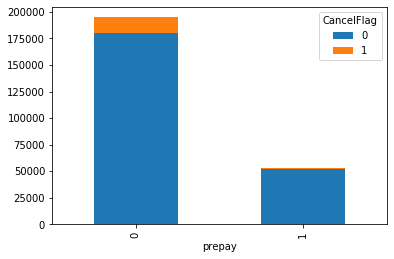

In [78]:
print(df.pivot_table('OrderID', 
                       'prepay', 'CancelFlag', 
                       'count').plot(kind='bar', stacked=True))

In [0]:
df['DiffDate'] = (df['Date'] - df['OrderDate']).dt.days

Дата доставки не может быть меньше даты заказа, эти данные следует удалить

In [0]:
df = df[df['DiffDate'] >= 0]

Предположим, что на отмену заказа влияют месяц и день недели заказа и доставки (предположение себя не оправдало, разве что в декабре доля отказов чуть выше)

In [0]:
df['OrderDateMonth'] = df['OrderDate'].dt.month
df['DateMonth'] = df['Date'].dt.month
df['OrderDateWeekDay'] = df['OrderDate'].dt.dayofweek
df['DateWeekDay'] = df['Date'].dt.dayofweek

In [32]:
df.groupby(['OrderDateMonth'])['CancelFlag'].mean()

OrderDateMonth
1     0.066939
2     0.069773
3     0.067796
4     0.063434
5     0.062248
6     0.064578
7     0.069851
8     0.066444
9     0.060084
10    0.062165
11    0.064206
12    0.080647
Name: CancelFlag, dtype: float64

In [31]:
pd.crosstab(df['OrderDateMonth'], df['CancelFlag'])

CancelFlag,0,1
OrderDateMonth,,
1,19849,1424
2,20465,1535
3,22234,1617
4,19548,1324
5,18590,1234
6,16455,1136
7,15793,1186
8,16790,1195
9,18209,1164


In [43]:
df.groupby(['DateWeekDay'])['CancelFlag'].mean()

DateWeekDay
0    0.064877
1    0.065289
2    0.068353
3    0.067562
4    0.067095
5    0.067719
6    0.066699
Name: CancelFlag, dtype: float64

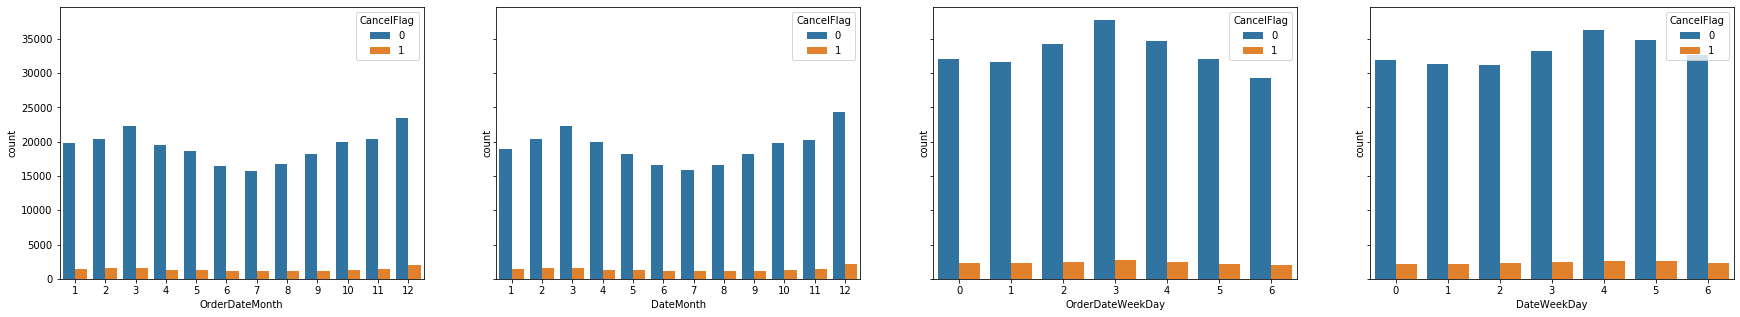

In [44]:
_, axes = plt.subplots(1, 4, sharey=True, figsize=(30,5))
sns.countplot(x='OrderDateMonth', hue='CancelFlag', data=df, ax=axes[0]);
sns.countplot(x='DateMonth', hue='CancelFlag', data=df, ax=axes[1]);
sns.countplot(x='OrderDateWeekDay', hue='CancelFlag', data=df, ax=axes[2]);
sns.countplot(x='DateWeekDay', hue='CancelFlag', data=df, ax=axes[3]);

Предположим, что на отказ влияет срок доставки. Да, это предположение вполне возможно и при построении модели стоит учесть данный фактор.

In [41]:
df.groupby(['DiffDate'])['CancelFlag'].mean().sort_values()

DiffDate
1     0.057309
0     0.059977
2     0.111242
3     0.130011
8     0.200000
11    0.200000
5     0.240000
7     0.272727
4     0.279891
12    0.285714
13    0.285714
6     0.325397
17    0.333333
10    0.333333
15    0.375000
14    0.500000
9     0.571429
22    0.600000
16    0.666667
19    0.666667
21    0.750000
18    0.833333
23    1.000000
24    1.000000
Name: CancelFlag, dtype: float64

In [39]:
df.DiffDate.value_counts()

1     197666
2      35589
0      12088
3       1746
4        736
5        275
6        126
7         11
8         10
15         8
14         8
13         7
12         7
9          7
18         6
11         5
22         5
21         4
10         3
16         3
17         3
19         3
24         2
23         1
Name: DiffDate, dtype: int64

Предположим, что пользователь мог ошибочно сделать второй заказ. Для этого сгруппируем выборгу по дате заказа и ClientID

In [0]:
df_group_by_client_date = df.groupby(['ClientID', 'Date'])

In [0]:
df_count_order_day = df_group_by_client_date.filter(lambda x: len(x) > 1)

Отменён может быть как первый, так и второй заказ(посмотреть, что происходит чаще). Докрутить аналогично с OrderDate + посмотреть зависимость с DiffDate

In [73]:
df_count_order_day.sort_values(['ClientID', 'Date', 'Interval', 'OrderID']).head(20)

,OrderID,Interval,Date,OrderDate,ClientID,ChannelID,MaterialID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit,Material,DiffDate,OrderDateMonth,DateMonth,OrderDateWeekDay,DateWeekDay
119608,98355619884,12-14.,2018-06-21,2018-06-20,2273,2,3323410,UNKNOWN,1,80,Обычная доставка,0,1,1474.661358,1,6,6,2,3
119615,98355619954,12-14.,2018-06-21,2018-06-20,2273,2,3330318,UNKNOWN,0,74,Обычная доставка,1,1,1474.661358,1,6,6,2,3
28136,98354561047,15-17.,2018-02-09,2018-02-08,5695,15,3263219,UNKNOWN,0,5,Обычная доставка,1,1,233.656208,1,2,2,3,4
28148,98354561199,15-17.,2018-02-09,2018-02-09,5695,15,3263219,UNKNOWN,1,5,Обычная доставка,0,2,233.656208,0,2,2,4,4
13462,98354382493,12-14.,2018-01-22,2018-01-21,19512,2,3306073,UNKNOWN,1,26,Обычная доставка,0,1,49.906568,1,1,1,6,0
13482,98354382641,6-8.,2018-01-22,2018-01-21,19512,2,2013606,UNKNOWN,0,70,Обычная доставка,1,1,24.336122,1,1,1,6,0
224024,98356922260,18-20.,2018-12-04,2018-12-02,27891,2,3311268,HUB17,1,18,Обычная доставка,0,1,9.431885,2,12,12,6,1
224048,98356922512,18-20.,2018-12-04,2018-12-02,27891,2,3357468,HUB17,0,21,Обычная доставка,0,1,86.412431,2,12,12,6,1
47261,98354801182,14-16.,2018-03-07,2018-03-05,46765,2,3243233,UNKNOWN,1,32,Обычная доставка,0,1,202.085690,2,3,3,0,2
47900,98354809420,16-18.,2018-03-07,2018-03-06,46765,2,3322332,UNKNOWN,0,33,Обычная доставка,0,4,123.322157,1,3,3,1,2


In [72]:
df_count_order_day.groupby(['ClientID', 'Date', 'Interval'])['CancelFlag'].mean()

ClientID   Date        Interval
2273       2018-06-21  12-14.      0.5
5695       2018-02-09  15-17.      0.5
19512      2018-01-22  12-14.      1.0
                       6-8.        0.0
27891      2018-12-04  18-20.      0.5
                                  ... 
100000056  2018-11-04  22-0.       1.0
                       22-2.       1.0
           2018-11-09  22-2.       1.0
           2018-11-10  22-0.       1.0
                       22-2.       1.0
Name: CancelFlag, Length: 11081, dtype: float64

Предположим, что пользователь сделал новый заказ, не дождавшись доставки предыдущего. Возможно стоит обратить вниматие на GroupID

Составить статистику по пользователю, насколько часто происходит отмена

Посмотреть попарную группировку признаков для выделения одного нового признака

# Логистическая регрессия (baseline)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [0]:
prepay_x = pd.get_dummies(df['prepay'].values, columns=['prepay']).values
diff_date_x = np.array([df.DiffDate.values])

In [0]:
x = np.concatenate([prepay_x, diff_date_x.T], axis=1)

In [0]:
y = df['CancelFlag'].values

In [0]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.33, random_state=42, stratify=y)

In [129]:
model = LogisticRegression(C=1e5, solver='newton-cg', max_iter=300, verbose=0, n_jobs=3)
model.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=300, multi_class='auto', n_jobs=3, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [130]:
model.score(x_train, y_train)

0.9331622318525241

In [131]:
model.score(x_test, y_test)

0.9331755058209065

In [142]:
model.predict_proba(x_test)

array([[0.9285582 , 0.0714418 ],
       [0.97612466, 0.02387534],
       [0.9285582 , 0.0714418 ],
       ...,
       [0.9285582 , 0.0714418 ],
       [0.9285582 , 0.0714418 ],
       [0.97612466, 0.02387534]])

In [143]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

# Тест

In [0]:
df_test = pd.read_csv('test_FeelAI.csv', parse_dates=['Date', 'OrderDate'], date_parser=parse_dates, encoding='cp1251')

In [0]:
df_result = pd.read_csv('result_FeelAI.csv', encoding='cp1251')

In [0]:
df_test = df_test.groupby(['OrderID']).first()

In [155]:
df_test

,Interval,Date,OrderDate,ClientID,ChannelID,MaterialID,GroupID,Cluster,OrderCnt,DeliveryType,prepay,count_edit,DiffDate,Score
OrderID,,,,,,,,,,,,,,
90102104012,10-18.,2018-10-17,2018-10-15,93411902,2,3294844.0,36.0,NaN,1.0,Обычная доставка,0,1,2,0.113090
90102104032,14-16.,2018-10-16,2018-10-15,93411902,2,3044338.0,36.0,NaN,1.0,Обычная доставка,0,1,1,0.071442
90102104034,18-20.,2018-10-16,2018-10-15,93411902,2,3294844.0,36.0,NaN,2.0,Обычная доставка,0,1,1,0.071442
90102104037,10-18.,2018-10-18,2018-10-16,93411902,2,3350718.0,61.0,NaN,1.0,Обычная доставка,0,1,2,0.113090
90102106006,22-0.,2018-10-18,2018-10-18,93696397,2,3324518.0,63.0,NaN,1.0,Обычная доставка,1,1,0,0.014544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98357277730,12-14.,2018-12-31,2018-12-30,677155,2,3357901.0,36.0,HUB5,1.0,Обычная доставка,0,1,1,0.071442
98357277815,12-14.,2018-12-31,2018-12-30,92140786,2,3356444.0,23.0,HUB5,1.0,Обычная доставка,0,1,1,0.071442
98357277874,12-14.,2018-12-31,2018-12-30,93837091,2,3331869.0,16.0,HUB5,1.0,Обычная доставка,0,1,1,0.071442


In [0]:
df_test['DiffDate'] = (df_test['Date'] - df_test['OrderDate']).dt.days

In [0]:
prepay_x_test = pd.get_dummies(df_test['prepay'].values, columns=['prepay']).values
diff_date_x_test = np.array([df_test.DiffDate.values])

In [0]:
x = np.concatenate([prepay_x_test, diff_date_x_test.T], axis=1)

In [0]:
pred = model.predict_proba(x)[:,1]

In [0]:
df_test['Score'] = pred

In [0]:
df_test['ID'] = df_test.index

In [0]:
df_test.loc[df_test.DiffDate < 0, ['Score']] = 0

In [0]:
df_test[['ID', 'Score']].to_csv('res_FeelAI_baseline.csv', index=False)